In [1]:
# import required libraries
import cv2
import matplotlib.pyplot as plt
import dlib
import numpy as np

In [2]:
# read image from file
name = "data\\2023_02_06_Altinget\\2023_02_06_Altinget\\0093_V.HEIC"
img = cv2.imread(name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


In [3]:
detector = dlib.get_frontal_face_detector()

In [4]:
detections = detector(img, 1)

In [5]:
sp = dlib.shape_predictor("haarcascades/shape_predictor_68_face_landmarks.dat")
faces = dlib.full_object_detections()
for det in detections:
    faces.append(sp(img, det))

In [6]:
bb = faces[0].rect

right_eye = [faces[0].part(i) for i in range(36, 42)]
left_eye = [faces[0].part(i) for i in range(42, 48)]

# find min and max x and y points of the eyes
right_eye_x = [point.x for point in right_eye]
right_eye_y = [point.y for point in right_eye]
left_eye_x = [point.x for point in left_eye]
left_eye_y = [point.y for point in left_eye]

eps = 25
right_eye_x_min = min(right_eye_x) - eps
right_eye_x_max = max(right_eye_x) + eps
right_eye_y_min = min(right_eye_y) - eps
right_eye_y_max = max(right_eye_y) + eps
left_eye_x_min = min(left_eye_x) - eps
left_eye_x_max = max(left_eye_x) + eps
left_eye_y_min = min(left_eye_y) - eps
left_eye_y_max = max(left_eye_y) + eps

# draw rectangle around the eyes
img_eyes = img.copy()
img_eyes = cv2.rectangle(img_eyes, (right_eye_x_min, right_eye_y_min), (right_eye_x_max, right_eye_y_max), (255, 0, 0), 2)
img_eyes = cv2.rectangle(img_eyes, (left_eye_x_min, left_eye_y_min), (left_eye_x_max, left_eye_y_max), (255, 0, 0), 2)

In [7]:
# crop eyes
right_eye_img = img[right_eye_y_min:right_eye_y_max, right_eye_x_min:right_eye_x_max]
left_eye_img = img[left_eye_y_min:left_eye_y_max, left_eye_x_min:left_eye_x_max]

C:\Users\pczum\AppData\Local\Temp\ipykernel_33424\918135435.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


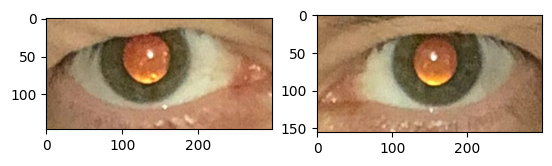

In [8]:
# plot eyes
fig, ax = plt.subplots(1, 2)
ax[0].imshow(right_eye_img)
ax[1].imshow(left_eye_img)
fig.show()

In [9]:
def find_left_activations(imgo):
    img = imgo.copy()
    output = []
    for i in range(img.shape[0]):
        row = img[i]
        first_nonzero = np.argmax(row)
        row[:first_nonzero] = 0
        row[first_nonzero:] = 0
        row[first_nonzero] = 255
        output.append(row)
    return remove_border(np.array(output))

def remove_border(img):
    img[:1] = 0
    img[-1:] = 0
    img[:, :1] = 0
    img[:, -1:] = 0
    return img

In [10]:
inp = right_eye_img
gray = cv2.cvtColor(inp, cv2.COLOR_BGR2GRAY)
reds = inp[:, :, 0]
# gaussian blur
reds = cv2.GaussianBlur(reds, (5, 5), 0)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
# right sobel
kernel = np.array([
    [-1, 0, 1], 
    [-2, 0, 2], 
    [-1, 0, 1]
])

# ------ iris ------
# convolve
sobelx = cv2.filter2D(gray, -1, kernel)
sobely = cv2.filter2D(gray, -1, kernel*-1)
sobel_top = cv2.filter2D(gray, -1, kernel.T)
sobel_bottom = cv2.filter2D(gray, -1, (kernel*-1).T)

# threshold
threshold = 60
sobelx = cv2.threshold(sobelx, threshold, 255, cv2.THRESH_BINARY)[1]
sobely = cv2.threshold(sobely, threshold, 255, cv2.THRESH_BINARY)[1]
sobel_top = cv2.threshold(sobel_top, threshold, 255, cv2.THRESH_BINARY)[1]
sobel_bottom = cv2.threshold(sobel_bottom, threshold, 255, cv2.THRESH_BINARY)[1]

## for each row in image, find the first non-zero element - everything else is set to 0
# flip image along y axis
iris_x = find_left_activations(cv2.flip(sobelx, 1))
iris_x = cv2.flip(iris_x, 1)
# get mean x of iris_x
iris_y = find_left_activations(sobely)
iris_top = find_left_activations(np.rot90(sobel_top, 3))
iris_top = np.rot90(iris_top, 1)
mean_y = np.mean(iris_y.nonzero()[1])
mean_x = np.mean(iris_x.nonzero()[1])
# constrain iris_top between mean_x and mean_y - outside is zero
iris_top[:, :int(mean_y)] = 0
iris_top[:, int(mean_x):] = 0

# merge
iris = cv2.bitwise_or(iris_x, iris_y)
iris = cv2.bitwise_or(iris, iris_top)

# ------ pupil ------
# convolve
sobelx = cv2.filter2D(reds, -1, kernel)
sobely = cv2.filter2D(reds, -1, kernel*-1)
sobel_top = cv2.filter2D(reds, -1, kernel.T)
sobel_bottom = cv2.filter2D(reds, -1, (kernel*-1).T)

# threshold
threshold = 80
sobelx = cv2.threshold(sobelx, threshold, 255, cv2.THRESH_BINARY)[1]
sobelx[int(mean_x):] = 0
sobelx[:, :int(mean_y)] = 0
sobely = cv2.threshold(sobely, threshold, 255, cv2.THRESH_BINARY)[1]
sobely[:, int(mean_x):] = 0
sobely[:, :int(mean_y)] = 0
sobel_top = cv2.threshold(sobel_top, threshold, 255, cv2.THRESH_BINARY)[1]

sobel_bottom = cv2.threshold(sobel_bottom, threshold, 255, cv2.THRESH_BINARY)[1]

pupil_x = find_left_activations(sobelx)
pupil_y = find_left_activations(cv2.flip(sobely, 1))
pupil_y = cv2.flip(pupil_y, 1)
pupil_top = find_left_activations(np.rot90(sobel_top, 1))
pupil_top = np.rot90(pupil_top, 3)
# get mean x of pupil_x
mean_x = np.mean(pupil_x.nonzero()[1])
pupil_x[:, int(mean_x):] = 0
mean_x = np.mean(pupil_x.nonzero()[1])
mean_y = np.mean(pupil_y.nonzero()[1])
pupil_y[:, :int(mean_y)] = 0
mean_y = np.mean(pupil_y.nonzero()[1])
# constrain pupil_top between mean_x and mean_y - outside is zero
pupil_top[:, :int(mean_x)] = 0
pupil_top[:, int(mean_y):] = 0

# merge
pupil = cv2.bitwise_or(pupil_x, pupil_y)
pupil = cv2.bitwise_or(pupil, pupil_top)


C:\Users\pczum\AppData\Local\Temp\ipykernel_33424\2323154788.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


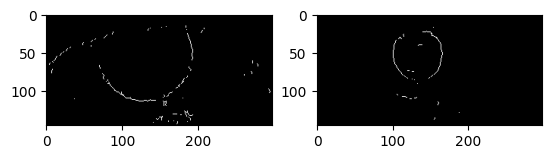

In [11]:
# plot pupil and iris
fig, ax = plt.subplots(1, 2)
ax[0].imshow(iris, cmap="gray")
ax[1].imshow(pupil, cmap="gray")
fig.show()

In [12]:
import numpy as np
import random

def calculate_circle_from_points(p1, p2, p3):
    """Calculate the circle passing through three points p1, p2, p3."""
    # Unpack points
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3

    # Calculate the circle center and radius using linear algebra
    A = np.array([[x1 - x2, y1 - y2], [x1 - x3, y1 - y3]])
    B = np.array([
        (x1 ** 2 - x2 ** 2 + y1 ** 2 - y2 ** 2) / 2,
        (x1 ** 2 - x3 ** 2 + y1 ** 2 - y3 ** 2) / 2
    ])

    try:
        # Solve for center (cx, cy)
        cx, cy = np.linalg.solve(A, B)
        radius = np.sqrt((cx - x1) ** 2 + (cy - y1) ** 2)
        return (cx, cy), radius
    except np.linalg.LinAlgError:
        # If points are collinear or close to it, return None
        return None, None

def ransac_circle(points, num_iterations=10000, threshold=1.00):
    """Fit a circle to the given points using RANSAC."""
    best_circle = None
    best_inliers = 0

    for _ in range(num_iterations):
        # Randomly sample 3 points
        sample_points = random.sample(points, 3)
        center, radius = calculate_circle_from_points(*sample_points)

        if center is None:
            continue  # Skip if points are collinear

        # Calculate inliers
        inliers = 0
        for p in points:
            dist = np.sqrt((p[0] - center[0]) ** 2 + (p[1] - center[1]) ** 2)
            if abs(dist - radius) <= threshold:
                inliers += 1

        # Update best circle if current one has more inliers
        if inliers > best_inliers:
            best_inliers = inliers
            best_circle = (center, radius)

    return best_circle


In [13]:
def get_circle(img):
    points = np.argwhere(img == 255)
    points = [tuple(point) for point in points]

    circle = ransac_circle(points, 100, 1.0)
    if circle:
        center, radius = circle
        print(f"Best circle found with center: {center} and radius: {radius}")
    else:
        print("No circle found")

    center = (round(center[1]), round(center[0]))
    radius = round(radius)
    return center, radius

Best circle found with center: (51.88607594936708, 129.60337552742615) and radius: 62.16845763813507


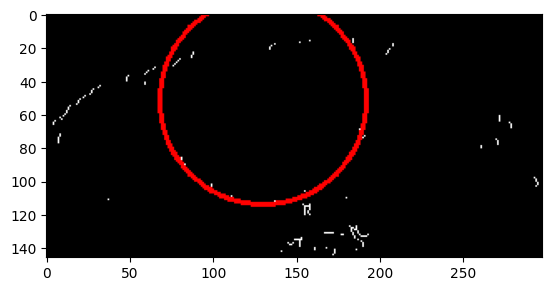

In [14]:
iris_center, iris_radius = get_circle(iris)
iris_circle = cv2.cvtColor(iris, cv2.COLOR_GRAY2RGB)
iris_circle = cv2.circle(iris_circle, iris_center, iris_radius, (255, 0, 0), 2)
plt.imshow(iris_circle)

Best circle found with center: (53.24657534246576, 132.66438356164386) and radius: 32.665314216485044


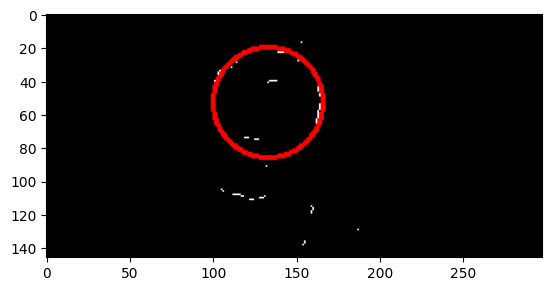

In [15]:
pupil_center, pupil_radius = get_circle(pupil)
pupil_circle = cv2.cvtColor(pupil, cv2.COLOR_GRAY2RGB)
pupil_circle = cv2.circle(pupil_circle, pupil_center, pupil_radius, (255, 0, 0), 2)
plt.imshow(pupil_circle)

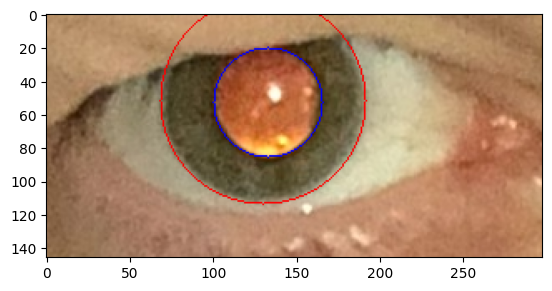

In [16]:
# draw circle on original image
img_circle = inp.copy()
img_circle = cv2.circle(img_circle, iris_center, iris_radius, (255, 0, 0), 1)
img_circle = cv2.circle(img_circle, pupil_center, pupil_radius, (0, 0, 255), 1)
plt.imshow(img_circle)

In [17]:
# Define the bounding box for the iris
x_min = max(iris_center[0] - iris_radius, 0)
x_max = min(iris_center[0] + iris_radius, inp.shape[1])
y_min = max(iris_center[1] - iris_radius, 0)
y_max = min(iris_center[1] + iris_radius, inp.shape[0])

pupil_center = (pupil_center[0] - x_min, pupil_center[1] - y_min)
pupil_radius = pupil_radius + 2
iris_center = (iris_center[0] - x_min, iris_center[1] - y_min)

# Crop the iris from the input image
iris_crop = inp[y_min:y_max, x_min:x_max]

# set pixels outside the iris to black
mask = np.zeros_like(iris_crop)
mask = cv2.circle(mask, iris_center, iris_radius, (255, 255, 255), -1)
iris_crop = cv2.bitwise_and(iris_crop, mask)

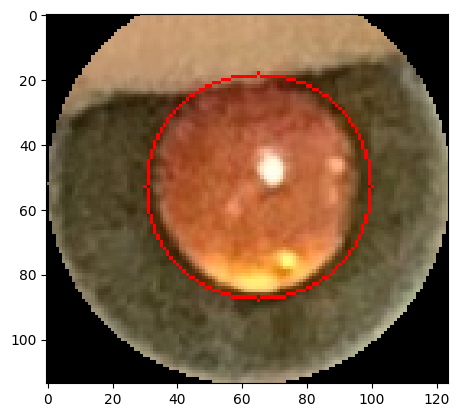

In [18]:
# draw pupil circle on cropped iris
iris_crop_circle = iris_crop.copy()
iris_crop_circle = cv2.circle(iris_crop_circle, pupil_center, pupil_radius, (255, 0, 0), 1)
plt.imshow(iris_crop_circle)

In [19]:
# otsu thresholding
gray = cv2.cvtColor(iris_crop, cv2.COLOR_RGB2GRAY)
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# set pixels inside the pupil to black
mask = np.zeros_like(thresh)
mask = cv2.circle(mask, pupil_center, pupil_radius, (255, 255, 255), -1)
mask = cv2.bitwise_not(mask)
thresh = cv2.bitwise_and(thresh, mask)
thresh = cv2.bitwise_not(thresh)

# mask iris with threshold
iris_crop_tmp = cv2.bitwise_and(iris_crop, iris_crop, mask=thresh)

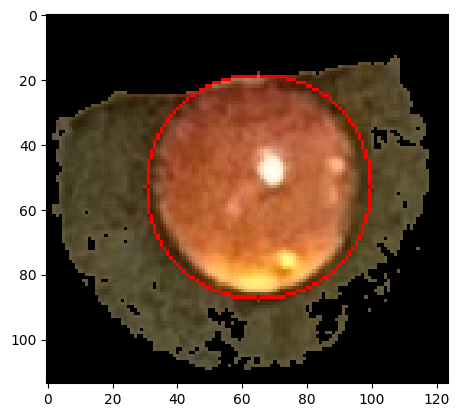

In [20]:
# draw pupil circle on cropped iris
iris_crop_circle = iris_crop_tmp.copy()
iris_crop_circle = cv2.circle(iris_crop_circle, pupil_center, pupil_radius, (255, 0, 0), 1)
plt.imshow(iris_crop_circle)